# Optic flow analysis

In [1]:
### optic flow dependencies
import os
import numpy as np
import pandas as pd
import xarray as xr
import cv2 as cv
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.backends.backend_pdf import PdfPages
import warnings
warnings.filterwarnings('ignore')
import ray
import matplotlib as mpl
import io_dict_to_hdf5 as ioh5

In [8]:
### load in shifter network-corrected world view
vid_file = r'\\goeppert\nlab-nas\freely_moving_ephys\optic_flow_data\070921\J553RT\Shifted_worldcam_dt025.npy'
wc_data = np.load(vid_file)
print(wc_data.shape)

(44654, 60, 80)


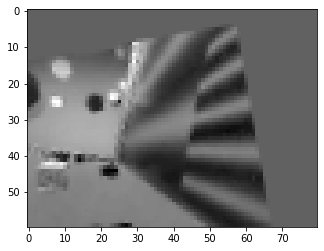

In [9]:
### show an example frame
plt.imshow(wc_data[100,:,:],cmap='gray')
plt.show()

In [10]:
### plot some example flow data in a pdf

nrows = 3 # to show raw, difference, and optic flow
ncols = 10 # number of example frames to plot
fig_scale=3 # how big to blow up the figure

# st_frame = 1000 #animal moves a bit
st_frame = 10000 #monitor view

nx=5 #downsample factor
scale=0.25
win=15

### initialize the figure
fig, axs = plt.subplots(nrows,ncols,figsize=(ncols*fig_scale,nrows*fig_scale))

### initialize the pdf
pdf_file = r'T:/freely_moving_ephys/%s_frame%d_bin%dX_win%d_scale%0.2f.pdf' % (os.path.split(vid_file)[-1][:-4],st_frame,nx,win,scale)
pp = PdfPages(pdf_file)

### loop through example frames, get flow, and plot everything
for f,fr in enumerate(np.arange(st_frame,st_frame+ncols,1)):

    prvs = wc_data[fr,:,:] # current frame
    next = wc_data[fr+1,:,:] # next frame

    w = prvs.shape[0]
    h = prvs.shape[1]
    X,Y = np.meshgrid(np.arange(0,h),np.arange(0,w))

    flow = cv.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, win, 3, 5, 1.2, 0) #(prvs,next, None, 0.5, 3, 3, 15, 5, 1.2, 0)
    # mag, ang = cv.cartToPolar(flow[...,0], flow[...,1])

    ### plot raw frame
    ax = axs[0,f]
    im = ax.imshow(prvs,cmap='gray',vmin=-2.5,vmax=2.5)
    ax.axis('off')

    ### plot raw difference
    ax = axs[1,f]
    im2 = ax.imshow(next-prvs,cmap='jet',vmin=-2.5,vmax=2.5)
    ax.axis('off')

    ### plot optic flow
    ax = axs[2,f]
    U = flow[:,:,0]
    V = flow[:,:,1]
    ax.quiver(X[::nx,::nx],Y[::nx,::nx],U[::nx,::nx],-V[::nx,::nx],scale=scale)
    ax.axis('off')

### make colorbar for raw data
ax = axs[0,f]   
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

### make colorbar for raw difference
ax = axs[1,f]   
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax)

### save figure to pdf and close both
pp.savefig(fig)
plt.close(fig)
pp.close()

print('finished making PDF!')

finished making PDF!


In [59]:
### calculate optic flow for the entire video
nx=5 #downsample factor
scale=0.25
win=5

fr = wc_data.shape[0]-1 # total number of frames in video (-1 since we're taking the difference between consecutive)
h = wc_data.shape[1] # image height
w = wc_data.shape[2] # image width
flow_data = np.zeros((fr,h,w,2)) # initialize optic flow array

### loop over all frames to get optic flow, populate array
for f in range(fr):
    flow = cv.calcOpticalFlowFarneback(wc_data[f,:,:],wc_data[f+1,:,:], None, 0.5, 3, win, 3, 5, 1.2, 0)
    flow_data[f,:,:,0] = flow[:,:,0]
    flow_data[f,:,:,1] = flow[:,:,1]

new_flow1 = np.reshape(flow_data,(flow_data.shape[0],flow_data.shape[1]*flow_data.shape[2],flow_data.shape[3]))
new_flow2 = np.reshape(new_flow,(flow_data.shape[0],flow_data.shape[1]*flow_data.shape[2]*flow_data.shape[3]))
new_flow2 = new_flow2.astype('float32')
### save out the data
np.save(r'T:\freely_moving_ephys\%s_flow_data_win%d.npy' % (os.path.split(vid_file)[-1][:-4],win),flow_data)

print('Finished saving %d frames to file!' % fr)

Finished saving 44653 frames to file!


(-0.5, 79.5, 59.5, -0.5)

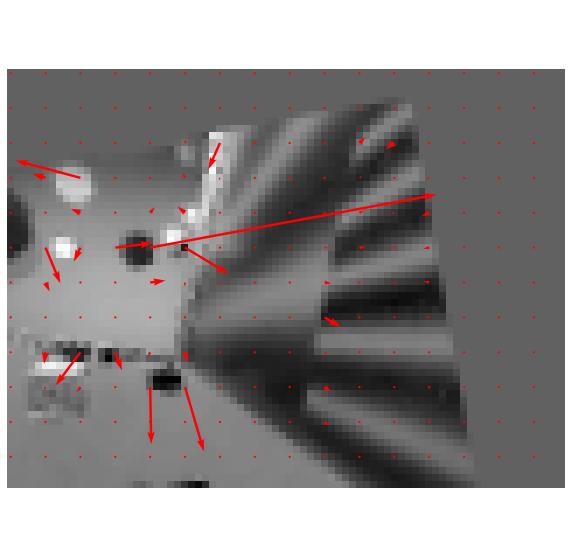

In [60]:
t=100
nx = 5
scale = 0.25

fig, ax = plt.subplots(1,1,figsize=(10,10))

# ax = axs[0]
ax.imshow(wc_data[t,:,:],cmap='gray')
ax.axis('off')
ax.axis('equal')

# ax = axs[1]
U = flow_data[t,:,:,0]
V = flow_data[t,:,:,1]
ax.quiver(X[::nx,::nx],Y[::nx,::nx],U[::nx,::nx],-V[::nx,::nx],scale=scale,color='r')
ax.axis('off')
ax.axis('equal')


In [56]:
### only run once

ray.init(ignore_reinit_error=True)
t=100
nx = 5
scale = 0.25

@ray.remote
def plot_optic_flow_movie(wc_data,flow_data,t,nx,scale):
    fig, ax = plt.subplots(1,1,figsize=(5,5))

    # ax = axs[0]
    ax.imshow(wc_data[t,:,:],cmap='gray')
    ax.axis('off')
    ax.axis('equal')

    # ax = axs[1]
    U = flow_data[t,:,:,0]
    V = flow_data[t,:,:,1]
    ax.quiver(X[::nx,::nx],Y[::nx,::nx],U[::nx,::nx],-V[::nx,::nx],scale=scale,color='r')
    # ax.axis('off')
    # ax.axis('equal')

    fig.tight_layout()

    width, height = fig.get_size_inches() * fig.get_dpi()
    fig.canvas.draw()       # draw the canvas, cache the renderer
    images = np.frombuffer(fig.canvas.tostring_rgb(),
                        dtype='uint8').reshape(int(height), int(width), 3)
    
    plt.close(fig)
    
    return images


2021-11-23 16:48:26,697	INFO worker.py:833 -- Calling ray.init() again after it has already been called.


In [61]:
mpl.use('agg')

# start = time.time()
##### initialize time points for animation and progressbar #####
st_frame = 10000
t = st_frame
dt = 10*50 #sec * fps
time_range = np.arange(t,t+dt)
# num_ticks = np.size(time_range)
# pb = ProgressBar(num_ticks)
# actor = pb.actor

##### Put large arrays into shared memory #####
time_range_r = ray.put(time_range)
wc_data_r = ray.put(wc_data)
flow_data_r = ray.put(flow_data)

##### Loop over parameters appending process ids #####
result_ids = []
for t in time_range:
    result_ids.append(plot_optic_flow_movie.remote(wc_data_r,flow_data_r,t,nx,scale))

##### pring progressbar and get results #####
# pb.print_until_done()
results_p = ray.get(result_ids)
images = np.stack([results_p[i] for i in range(len(results_p))])

##### Make video with opencv #####
aniname = 'optic_flow_test_stfr%d.mp4' % st_frame
vid_name = r'T:/freely_moving_ephys/' + aniname
frame_dt = 0.025
t_down = 4
FPS = int(1/(frame_dt*t_down))
out = cv.VideoWriter(vid_name, cv.VideoWriter_fourcc(*'mp4v'), FPS, (images.shape[-2], images.shape[-3]))

for fm in range(images.shape[0]):
    out.write(cv.cvtColor(images[fm], cv.COLOR_BGR2RGB))
out.release()
# print('Making Animation {}: {}'.format(aniname, time.time()-start))
# del results_p, time_range_r, model_vid_sm_r, model_gz_r, model_th_r, model_phi_r, pb
# gc.collect()


In [29]:
U.shape

(60, 80)

In [18]:
new_flow = np.reshape(new_flow2,(new_flow2.shape[0],60*80,2))
flow_data = np.reshape(new_flow,(new_flow2.shape[0],60,80,2))
flow_data.shape

(44653, 60, 80, 2)

# Ephys w/optic flow

In [2]:
### only run once

# ray.init(ignore_reinit_error=True)

### load the flow data (has only activate times)
win = 5
vid_file = r'\\goeppert\nlab-nas\freely_moving_ephys\optic_flow_data\070921\J553RT\Shifted_worldcam_dt025.npy'
flow_data = np.load(r'T:\freely_moving_ephys\%s_flow_data_win%d.npy' % (os.path.split(vid_file)[-1][:-4],win))
print('loaded flow data!')

### load the ephys data and remove inactive times
model_data_file = r'\\goeppert\nlab-nas\freely_moving_ephys\optic_flow_data\070921\J553RT\ModelData_dt025_rawWorldCam.h5'
data = ioh5.load(model_data_file)
##### Find 'good' timepoints when mouse is active #####
nan_idxs = []
for key in data.keys():
    nan_idxs.append(np.where(np.isnan(data[key]))[0])
good_idxs = np.ones(len(data['model_active']),dtype=bool)
good_idxs[data['model_active']<.5] = False
good_idxs[np.unique(np.hstack(nan_idxs))] = False

data['raw_nsp'] = data['model_nsp'].copy()
##### return only active data #####
for key in data.keys():
    if (key != 'model_nsp') & (key != 'model_active') & (key != 'unit_nums'):
        data[key] = data[key][good_idxs] # interp_nans(data[key]).astype(float)
    elif (key == 'model_nsp'):
        data[key] = data[key][good_idxs]
    elif (key == 'unit_nums'):
        pass

model_nsp = data['model_nsp']
n_units = model_nsp.shape[0]
print('loaded ephys data!')

# ephys_file = r'\\goeppert\nlab-nas\freely_moving_ephys\ephys_recordings\070921\J553RT\fm1\070921_J553RT_control_Rig2_fm1_ephys_props.h5'
# ephys = pd.read_hdf(ephys_file)
# ephys_data = pd.read_json(r'\\goeppert\nlab-nas\freely_moving_ephys\ephys_recordings\070921\J553RT\fm1\070921_J553RT_control_Rig2_fm1_ephys_merge.json')
# # sort units by shank and site order
# ephys_data = ephys_data.sort_values(by='ch', axis=0, ascending=True)
# ephys_data = ephys_data.reset_index()
# ephys_data = ephys_data.drop('index', axis=1)
# # spike times
# ephys_data['spikeTraw'] = ephys_data['spikeT']
# print('getting good cells')
# # select good cells from phy2
# goodcells = ephys_data.loc[ephys_data['group']=='good']
# units = goodcells.index.values
# # get number of good units
# n_units = len(goodcells)

# world_data = xr.open_dataset(r'\\goeppert\nlab-nas\freely_moving_ephys\ephys_recordings\070921\J553RT\fm1\070921_J553RT_control_Rig2_fm1_world.nc')
# ephysT0 = ephys_data.iloc[0,12]
# worldT = world_data.timestamps.copy() - ephysT0

# # model setup
# model_dt = 0.025
# model_t = np.arange(0, np.max(worldT), model_dt)
# model_nsp = np.zeros((n_units, len(model_t)))
# # get binned spike rate
# bins = np.append(model_t, model_t[-1]+model_dt)
# for i in range(n_units):
#     model_nsp[i,:], bins = np.histogram(ephys['spikeT'].iloc[0], bins)

lags = [0]#np.arange(-2,3)
model_vid = flow_data.copy()
nks=(60,80,2)


loaded flow data!
loaded ephys data!


In [3]:

def calc_flow_STAs(model_vid,model_nsp,n_units,lags,nks):
    staAll = np.zeros((len(lags),n_units,nks[0],nks[1],nks[2]))
    for l,lag in enumerate(lags):
        for c in range(n_units):
            print('doing unit %d lag %d of %d' % (c,(l+1),len(lags)))
            sp = model_nsp[:,c].copy()
            sp = np.roll(sp, -lag)
            sta = model_vid.T @ sp
            sta = np.reshape(sta, nks)
            nsp = np.sum(sp)
            if nsp > 0:
                sta = sta/nsp
            else:
                sta = np.nan
            staAll[l,c,:,:,:] = sta
        print('finished lag %d' % lag)
    return staAll

In [7]:
staAll = calc_flow_STAs(model_vid,model_nsp[:-1,:],n_units,lags,nks)

doing unit 0 lag 1 of 1


In [26]:

### plot results
scale=0.25
h = 60
w = 80
X,Y = np.meshgrid(np.arange(0,w),np.arange(0,h))
nx=5

pdf_file = r'T:/freely_moving_ephys/%s_flowSTAs_bin%dX_win%d_scale%0.2f.pdf' % (os.path.split(vid_file)[-1][:-4],nx,win,scale)
pp = PdfPages(pdf_file)

fig, axs = plt.subplots(n_units,len(lags))
for l,lag in enumerate(lags):
    for c, ind in enumerate(goodcells.index):
        ax = axs[c,l]
        sta = staAll[l,c,:,:,:]
        U = sta[:,:,0]
        V = sta[:,:,1]
        ax.quiver(X[::nx,::nx],Y[::nx,::nx],U[::nx,::nx],-V[::nx,::nx],scale=scale)
        ax.axis['off']

fig.tight_layout()
pp.savefig(fig)
plt.close(fig)
pp.close()

        # ch = int(goodcells.at[ind,'ch'])
        # if ch_count == 64 or ch_count == 128:
        #     shank = np.floor(ch/32); site = np.mod(ch,32)
        # else:
        #     shank = 0; site = ch
        # if show_title:
        #     ax.title(f'ind={ind!s} nsp={nsp!s}\n ch={ch!s} shank={shank!s}\n site={site!s}',fontsize=4)
        # ax.axis('off')

(44653, 60, 80, 2)

# Group eye movement analysis

In [109]:
### dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import warnings
warnings.filterwarnings('ignore')

### functions

def xy_axis(ax):
    
    ### Removes the top and right bounding axes that are plotted by default in matplotlib
    
    ### INPUTS
    ### ax: axis object (e.g. from fig,ax = plt.subplots(1,1))
    
    ### OUTPUTS
    ### ax: the same axis w/top and right lines removed
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    return ax

print('finished loading dependencies')

def plot_group_eye_head_traces(df,sacs,mov_type,eye_head,baselines,baseline_pts,trace_range,trange,save_pdf,pp,sup):
    
    ### plots clustered traces of spiking vs. eye/head movements and saves a pdf (optional)
    
    ### INPUTS
    ### recs: list of recordings names, e.g. ['fm1']
    ### sacs: list of saccade labels, e.g. ['upsacc','downsacc']
    ### mov_type: list of movement types, e.g. ['gaze_shift','comp']
    ### eye_head: list of eye/head movement labels, e.g. ['dEye','dHead']
    ### trace_range: time range you want to plot over, e.g. [-0.25,0.5]
    ### trange: time points for traces, current is np.arange(-1,1.1-0.025,0.025)
    ### baselines: list of booleans if you want to baseline traces or not, e.g. [True,False]
    ### baseline_pts: indices to use for baseline subtraction, e.g. np.arange(20,36)
    ### save_pdf: boolean value for if you want to save a pdf, e.g. True
    
    ### OUTPUTS
    ### currently none
    
    for rec in recs:
        for eh in eye_head:
            for baseline in baselines:
                fig, axs = plt.subplots(len(mov_type),len(sacs),figsize=(5*len(sacs),5*len(mov_type)))
                for m,m_t in enumerate(mov_type):
                    for s,sac in enumerate(sacs):
                        trace_label = '%s_%s_avg_%s_%s' % (rec,sac,m_t,eh)
                        cluster = trace_label + '_cluster'
#                         cluster = 'fm1_upsacc_avg_gaze_shift_dEye_cluster' #% (eh)
                        clusts = np.unique(df[cluster])
                        len_trace = len(df[trace_label].iloc[-1])

                        for clust in clusts:
                            clust_df = df[df[cluster]==clust]
                            clust_df.reset_index(inplace=True,drop=True)
#                             cluster_label = clust_df[cluster + '_type'].iloc[0]
                            sessions = np.unique(clust_df['session'])
                            num_sess = len(np.unique(clust_df['session']))
                            all_sess = np.zeros((num_sess,len_trace))
                            for se,sess in enumerate(sessions):
                                sess_df = clust_df[clust_df['session']==sess]
                                if len(sess_df)>0:
                                    sess_df.reset_index(inplace=True,drop=True)
                                    sess_array = np.zeros((len(sess_df),len_trace))
                                    for t,trace in enumerate(sess_df[trace_label]):
                                        sess_array[t,:] = trace
                                    all_sess[se,:] = np.nanmean(sess_array,axis=0)
                                else:
                                    sess_array = np.empty(len_trace)
                                    sess_array[:] = np.nan
                                    all_sess[se,:] = sess_array

                            ax = axs[m,s]
                            x = trange
                            y=np.nanmean(all_sess,axis=0)
                            if baseline:
                                y-=np.nanmean(y[baseline_pts])
                            err = np.nanstd(all_sess,axis=0)/np.sqrt(num_sess)

                            ax.plot(x,y,'-',label=str(clust))
                            ax.fill_between(x,y-err,y+err,alpha=0.2)
                        ax.set_xlabel('time from movement (s)')
                        ax.set_title(trace_label)
                        ax.set_xlim(trace_range[0],trace_range[1])
                        if baseline:
                            ax.set_ylim(-15,15)
                            ax.set_ylabel('baselined sp/s')
                        else:
                            ax.set_ylim(0,40)
                            ax.set_ylabel('sp/s')
                        ax = xy_axis(ax)
                        ax.legend(fontsize=8)
                fig.tight_layout()
                if save_pdf:
                    pp.savefig(fig)
                    plt.close(fig)

    print('finished adding eye/head plots to PDF!')

finished loading dependencies


# Load the data

In [11]:
group_file = r'\\Goeppert\nlab-nas\freely_moving_ephys\batch_files\092221\pooled_ephys_population_update_092221.pickle'
df = pd.read_pickle(group_file)

# remove inserted column if it exists
try:
    del df['level_0']
except:
    pass

# set up PDF

In [110]:
pdf_file = r'T:/freely_moving_ephys/group_analysis_cluster.pdf'
pp = PdfPages(pdf_file)

# Plot firing rate around eye/head movements for all sessions

In [111]:
recs = ['fm1'] #list of recording names
sacs = ['upsacc','downsacc'] #list of saccade names
mov_type = ['gaze_shift','comp'] #list of movement types
eye_head = ['dEye','dHead'] #list of eye/head variables
trace_range = [-0.25,0.5] #time range to plot traces over
trange = np.arange(-1,1.1-0.025,0.025) #time points for traces
baselines=[True,False] #do you want to baseline or do not or do both
baseline_pts = np.arange(20,36) #indices for baselining
save_pdf=True #do you want to save pdf
sup = 'grouped by own cluster'
plot_group_eye_head_traces(df,sacs,mov_type,eye_head,baselines,baseline_pts,trace_range,trange,save_pdf,pp,sup)

finished adding eye/head plots to PDF!


# Close the PDF

In [112]:
pp.close()

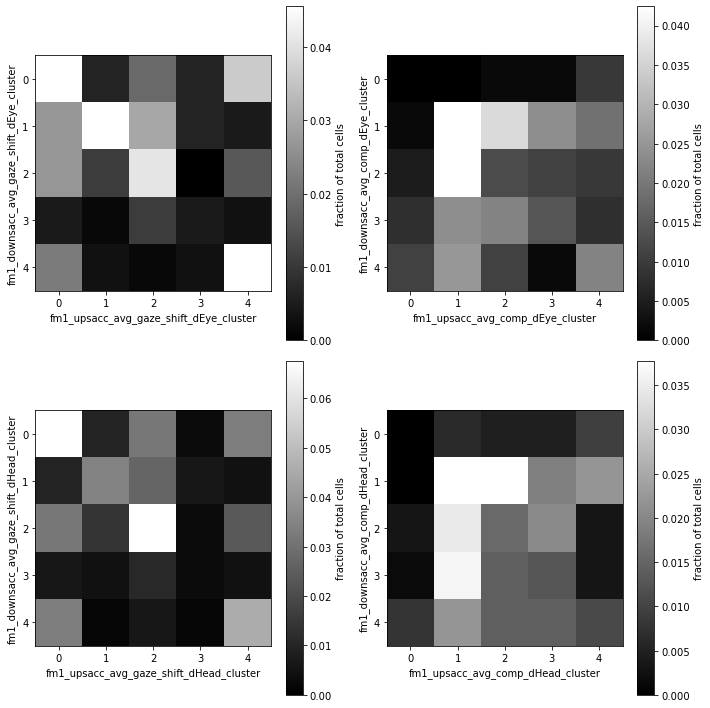

In [60]:
rec = 'fm1'
fig, axs = plt.subplots(2,2,figsize=(10,10))
axs=axs.ravel()
cnt=0
for eh in eye_head:
    for m,m_t in enumerate(mov_type):
        
        up_clust = 'fm1_upsacc_avg_%s_%s_cluster' % (m_t,eh)
        down_clust = 'fm1_downsacc_avg_%s_%s_cluster' % (m_t,eh)
        
        delta_array = np.zeros([5,5])
        for index,row in df.iterrows():
            up_ind = int(row[up_clust])
            down_ind = int(row[down_clust])
            delta_array[up_ind,down_ind] = delta_array[up_ind,down_ind] + 1
        delta_array /= len(df)
        
        da = delta_array.copy()
        idx = np.unravel_index(np.argmax(da), da.shape)
        da[idx[0],idx[1]]=0
        
        ax = axs[cnt]
        pos = ax.imshow(delta_array,cmap='gray',vmin=0,vmax=np.amax(da))
        ax.set_xlabel(up_clust)
        ax.set_ylabel(down_clust)
        cbar = plt.colorbar(pos,ax=ax)
        cbar.set_label('fraction of total cells')
        
        cnt+=1
fig.tight_layout()

In [81]:
df.shape

(636, 530)

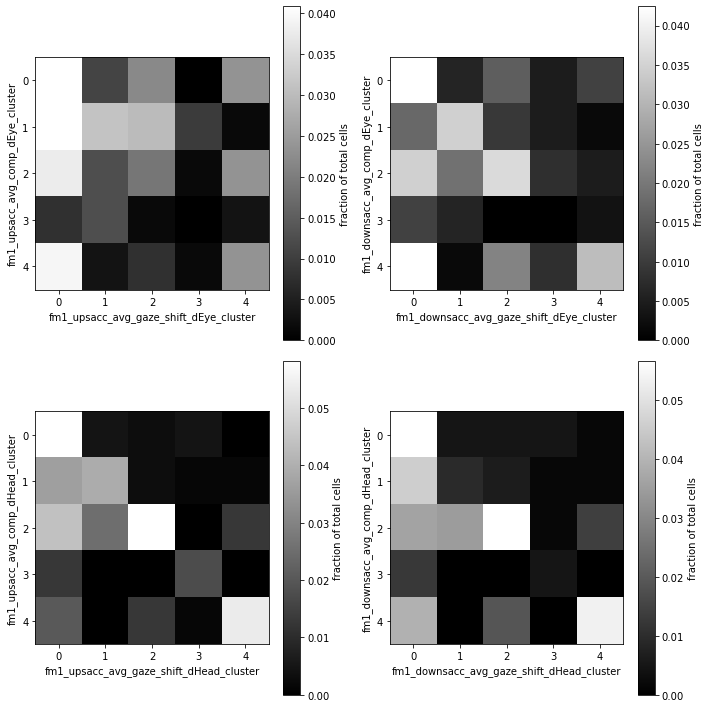

In [82]:
rec = 'fm1'
fig, axs = plt.subplots(2,2,figsize=(10,10))
axs=axs.ravel()
cnt=0
comp_remap = [3.,0.,2.,4.,1.]
for eh in eye_head:
    for s,sac in enumerate(sacs):
        
        up_clust = 'fm1_%s_avg_gaze_shift_%s_cluster' % (sac,eh)
        down_clust = 'fm1_%s_avg_comp_%s_cluster' % (sac,eh)
        
        
        comp_remap_type = []
        for index,row in df.iterrows():
            comp_remap_type.append(comp_remap[int(row[down_clust])])
            
        df['comp_remap_type'] = comp_remap_type
        
        delta_array = np.zeros([5,5])
        for index,row in df.iterrows():
            up_ind = int(row[up_clust])
            down_ind = int(row['comp_remap_type'])
            delta_array[up_ind,down_ind] = delta_array[up_ind,down_ind] + 1
        delta_array /= len(df)
        
        da = delta_array.copy()
        idx = np.unravel_index(np.argmax(da), da.shape)
        da[idx[0],idx[1]]=0
        
        ax = axs[cnt]
        pos = ax.imshow(delta_array,cmap='gray',vmin=0,vmax=np.amax(da))
        ax.set_xlabel(up_clust)
        ax.set_ylabel(down_clust)
        cbar = plt.colorbar(pos,ax=ax)
        cbar.set_label('fraction of total cells')
        
        cnt+=1
fig.tight_layout()

In [101]:
delta_array

array([[0.64779874, 0.00471698, 0.00471698, 0.00471698, 0.00157233],
       [0.04559748, 0.00943396, 0.00628931, 0.00157233, 0.00157233],
       [0.03616352, 0.03459119, 0.05660377, 0.00157233, 0.01415094],
       [0.01257862, 0.        , 0.        , 0.00471698, 0.        ],
       [0.03930818, 0.        , 0.01886792, 0.        , 0.05345912]])

In [76]:
up_clust = 'fm1_%s_avg_gaze_shift_%s_cluster_type' % (sac,eh)
down_clust = 'fm1_%s_avg_comp_%s_cluster_type' % (sac,eh)

In [77]:
np.unique(df[up_clust])

array(['biphasic', 'early', 'late', 'negative', 'unresponsive'],
      dtype=object)

In [ ]:
#gaze
#0 = unresponsive
#1 = biphasic
#2 = late
#3 = negative
#4 = early

#comp
#0 = negative
#1 = unresponsive
#2 = late
#3 = early
#4 = biphasic

comp_remap = [3,0,2,4,1]
comp_remap_type = []
for index,row in df.iterrows():
    comp_remap_type.append(comp_remap[row[down_clust]])

In [75]:
df.columns.values

array(['index', 'Amplitude', 'ContamPct', 'KSLabel', 'amp', 'ch', 'depth',
       'fr', 'group', 'fm1_n_spikes', 'sh', 'waveform', 'fm1_spikeT',
       't0', 'fm1_spikeTraw', 'fm1_rate', 'fm1_c_range', 'fm1_crf_cent',
       'fm1_crf_tuning', 'fm1_crf_err', 'fm1_spike_triggered_average',
       'fm1_sta_shape', 'fm1_spike_triggered_variance', 'fm1_upsacc_avg',
       'fm1_downsacc_avg', 'fm1_upsacc_avg_gaze_shift_dEye',
       'fm1_downsacc_avg_gaze_shift_dEye', 'fm1_upsacc_avg_comp_dEye',
       'fm1_downsacc_avg_comp_dEye', 'fm1_upsacc_avg_gaze_shift_dHead',
       'fm1_downsacc_avg_gaze_shift_dHead', 'fm1_upsacc_avg_comp_dHead',
       'fm1_downsacc_avg_comp_dHead',
       'fm1_spike_rate_vs_pupil_radius_cent',
       'fm1_spike_rate_vs_pupil_radius_tuning',
       'fm1_spike_rate_vs_pupil_radius_err',
       'fm1_spike_rate_vs_theta_cent', 'fm1_spike_rate_vs_theta_tuning',
       'fm1_spike_rate_vs_theta_err', 'fm1_spike_rate_vs_gz_cent',
       'fm1_spike_rate_vs_gz_tuning', 'fm1_